# Country segmentation using clustering techniques

This data is taken from the Kaggle dataset linked below. It consists of statistics on 167 countries relating to their socio-economic and health status.

We will explore the use of clustering techniques to see if an unsupervised learning algorithm can group countries into meaningful segmentations.

https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

In [115]:
df = pd.read_csv('Country-data.csv')

In [4]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Variable Descriptions
From data dictionary


- **country**: Name of the country
- **child_mort**: Death of children under 5 years of age per 1000 live births
- **exports**: Exports of goods and services per capita. Given as %age of the GDP per capital
- **health**: Total health spending per capita. Given as %age of GDP per capita
- **imports**: Imports of goods and services per capita. Given as %age of the GDP per capita
- **income**: Net income per person
- **iflation**: The measurement of the annual growth rate of the Total GDP
- **life_expect**: The average number of years a new born child would live if the current mortality patterns are to remain the same
- **total_fer**: The number of children that would be born to each woman if the current age-fertility rates remain the same.
- **gdpp**: The GDP per capita. Calculated as the Total GDP divided by the total population.

## Remove duplicate records

In [5]:
initial_no=df.shape[0]
print("Number of records: ",initial_no)
df.drop_duplicates(inplace=True)
print(initial_no-df.shape[0],"records with identical data removed")
print("Number of records after removing duplicates: ",df.shape[0])

Number of records:  167
0 records with identical data removed
Number of records after removing duplicates:  167


In [5]:
df.isnull().sum()/len(df)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

## Univariate Analysis

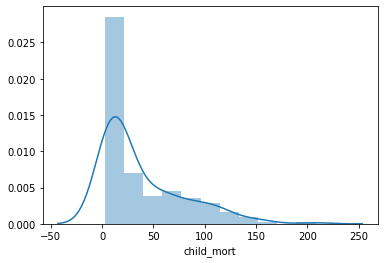

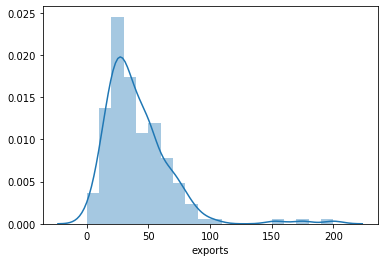

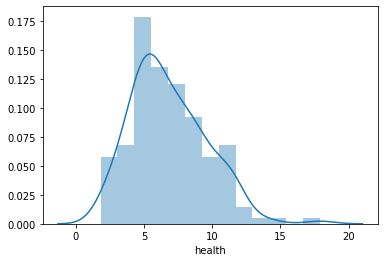

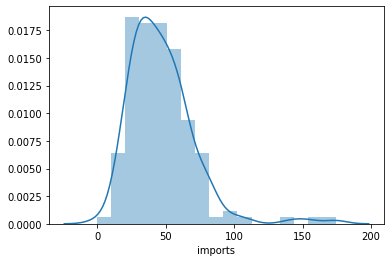

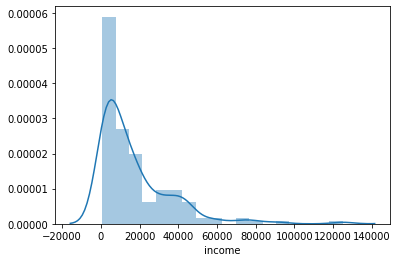

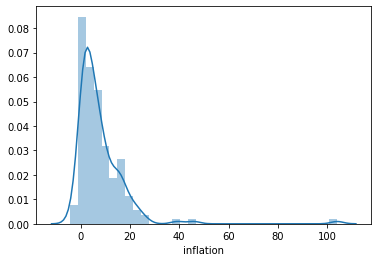

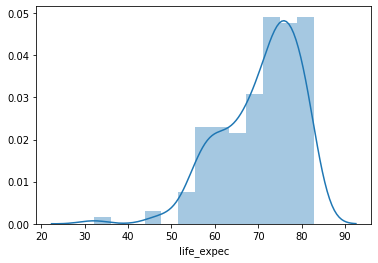

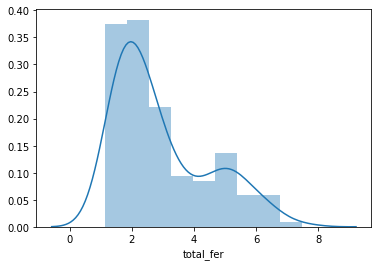

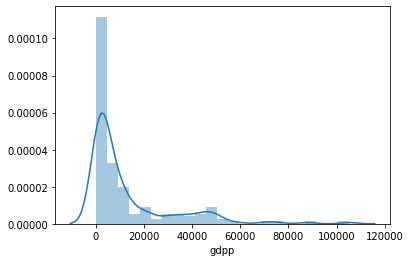

In [8]:
for column in df.drop(['country'],axis=1).columns.tolist():
    sns.distplot(df[column])
    plt.show();

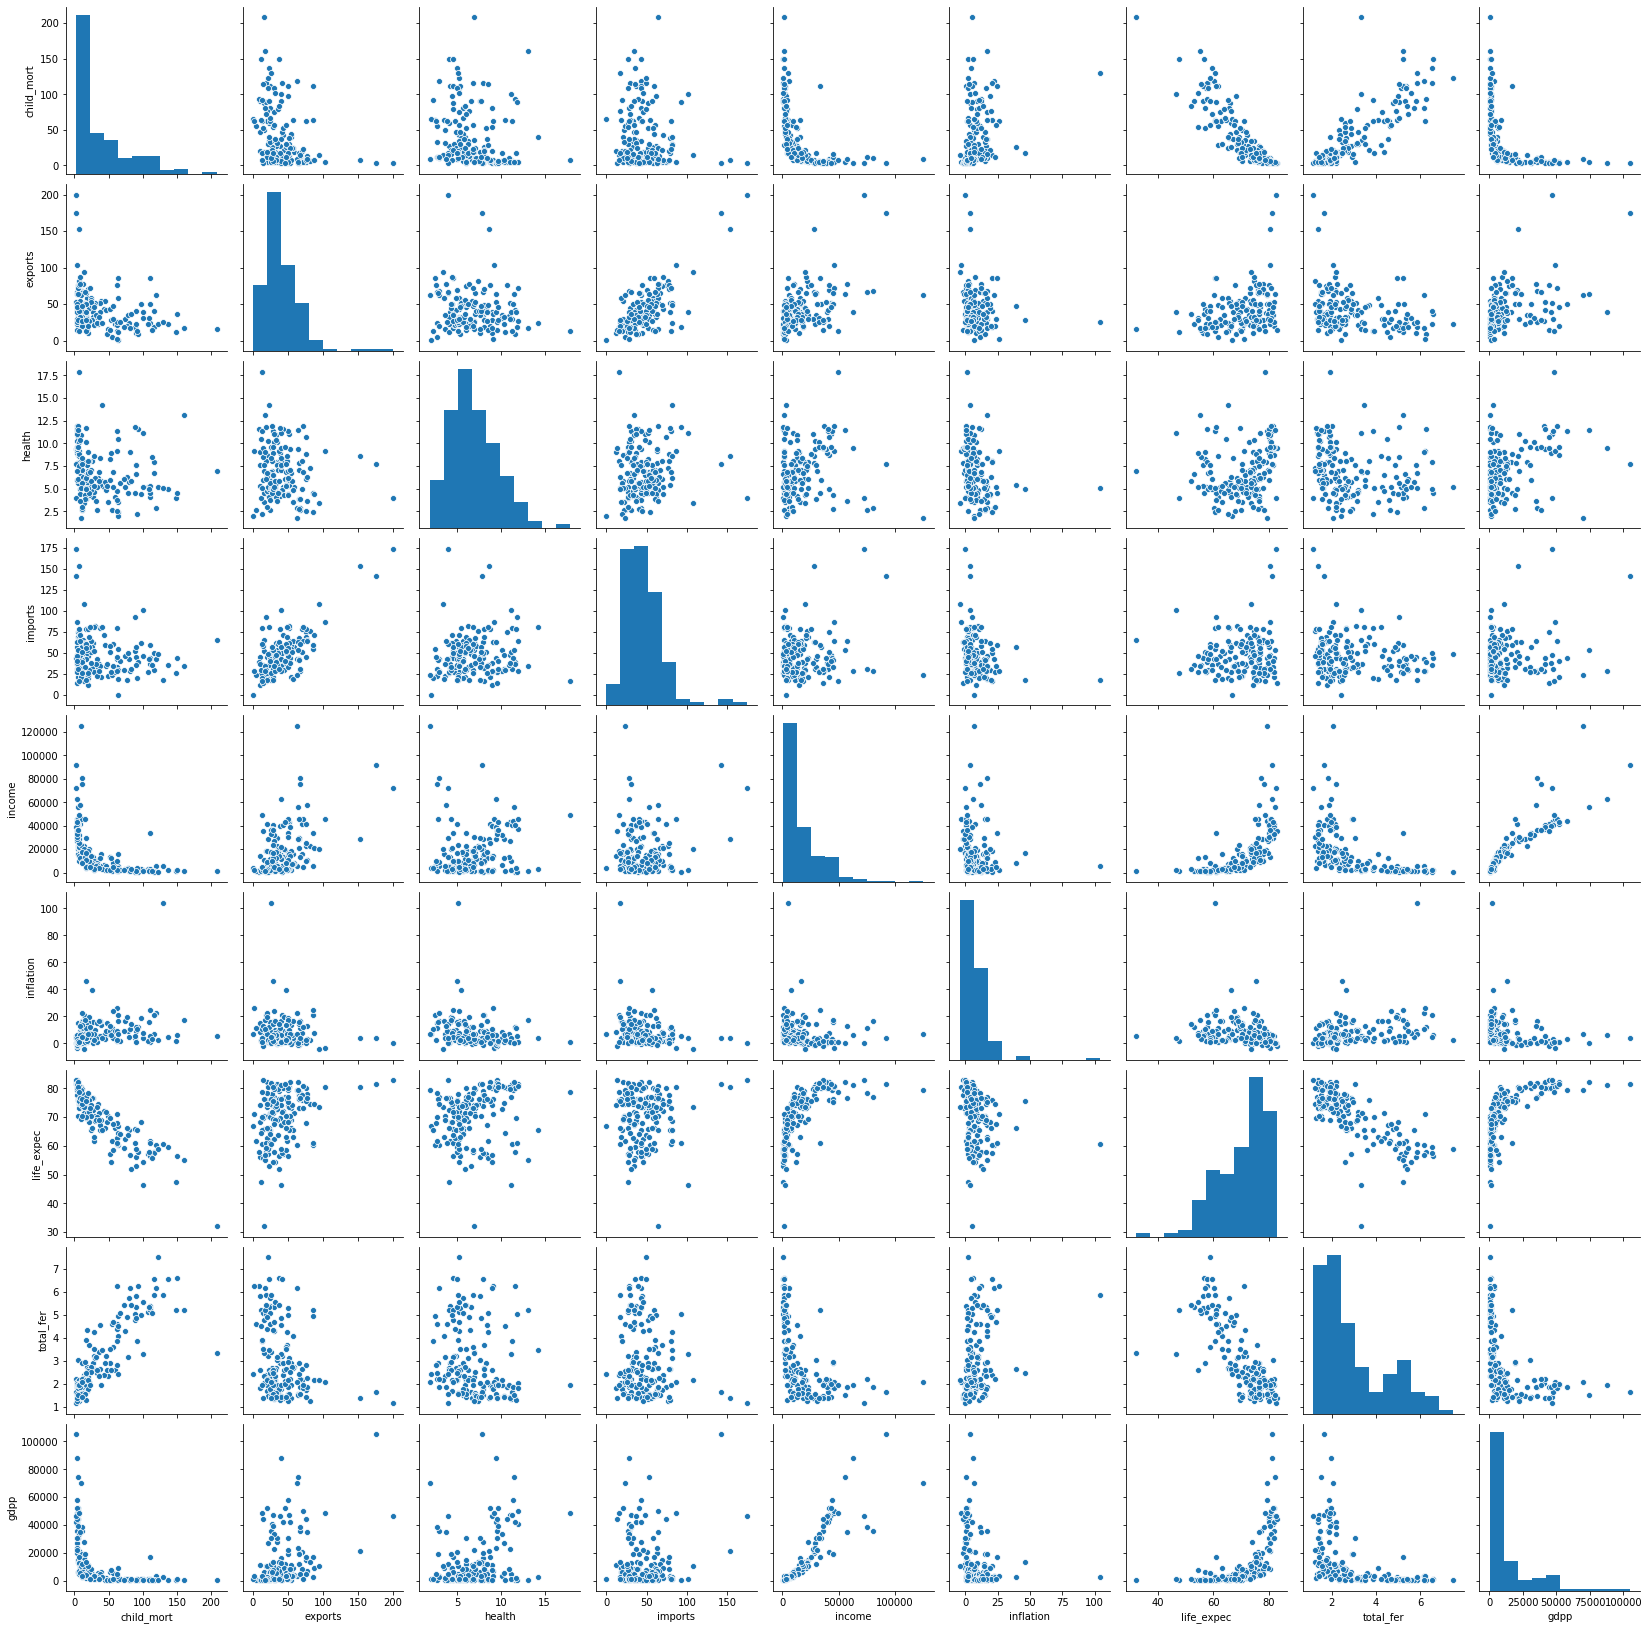

In [9]:
sns.pairplot(df)

Many features are visibly correlated:
    
 - Strong positive correlation between income and GDP per capita (naturally)
 - Strong negative correlation between life expectancy and child mortality (naturally)
 - Negative correlation between fertility rate and life expectancy

# Scale variables

Many features are on very different scales and our clustering will use distance-based algorithms, so it's important to rescale the features to ensure those with larger scales do not dominate the distance measure (e.g. income and GDP per person which are in the tens of thousands).

In [116]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(df.drop('country',axis=1).values),columns=df.drop('country',axis=1).columns)

In [117]:
X_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


# K-Means Clustering Algorithm

K-Means algorithm will start with a specified number (K) of randomly chosen points which will be the centres of the initial clusters. Data points are assigned to the cluster they are closest to in distance - the average of all data points in each cluster becomes the new centre point, then data points are re-assigned to the closest cluster centre point etc.

Inertia measures the average distance between each data point and the centroid of the cluster the algorithm has assigned it to. 
Naturally this decreases as K increases, as the data points are broken up into smaller/more granular segments.

A good rule of thumb to choose the optimum 'K' is the 'elbow' method - choosing the point at which inertia starts decreasing linearly

C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


Text(0.5, 1.0, 'Number of clusters - inertia')

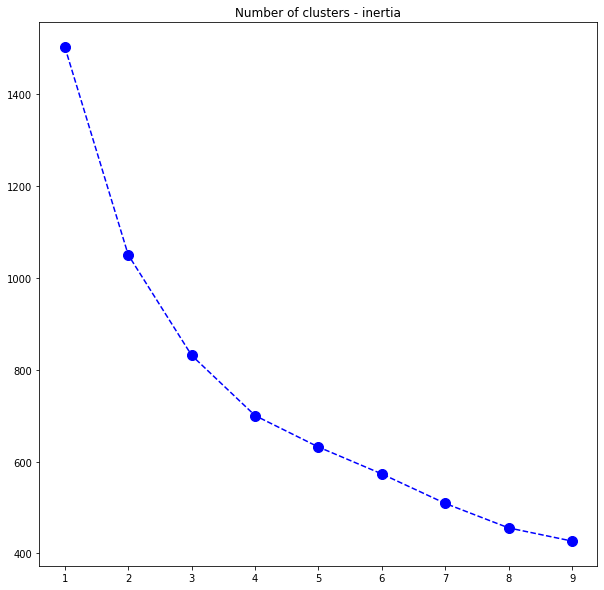

In [50]:

inertia = []

for i in range(1, 10):
    km = KMeans(n_clusters = i , init = 'k-means++')
    km.fit(X_scaled)
    inertia.append(km.inertia_)

fig=plt.figure(figsize=(10,10))
plt.plot(range(1,10),inertia,color='blue', linestyle='dashed', marker='o',markerfacecolor='Blue', markersize=10,label='Inertia')
plt.title('Number of clusters - inertia')

It looks like the 'elbow' above is around K=4, so we'll run K-means with this.

In [124]:
#--------Run k-means ------------
km = KMeans(n_clusters = 4 , init = 'k-means++')
km.fit(X_scaled)
df['cluster_kmeans'] = km.labels_

#--------Cluster volumes and centre points------------

print('Number of countries in each cluster')
display(df['cluster_kmeans'].value_counts().sort_index())

clusters = pd.DataFrame(km.cluster_centers_,index=[0,1,2,3],columns=X_scaled.columns.tolist())
print('Cluster centres')
display(clusters)


#--------Calculate distances between each point and the centre of its cluster------------

distances=[]

for i in range(len(km.labels_)):
    cluster=km.labels_[i]
    distances.append(np.linalg.norm(X_scaled.iloc[i].values-km.cluster_centers_[cluster]))
    
df['kmeans_centrdist'] = distances


#--------Show countries in each cluster that are most representative (closest to clustre centre)------------
for i in range(4):
    print('Countries in cluster ',i)
    display(df[df['cluster_kmeans']==i].sort_values('kmeans_centrdist').head(10))

Number of countries in each cluster


0    47
1    32
2    85
3     3
Name: cluster_kmeans, dtype: int64

Cluster centres


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.360218,-0.437533,-0.155984,-0.189204,-0.686894,0.402111,-1.282180,1.364944,-0.604242
1,-0.822941,0.183308,0.829894,-0.261252,1.398378,-0.499856,1.074331,-0.768250,1.595436
2,-0.412343,-0.001280,-0.225893,0.042453,-0.232738,-0.016367,0.261216,-0.428844,-0.352670
3,-0.849003,4.935673,-0.008163,4.548058,2.439542,-0.504206,1.226824,-1.038863,2.440797


Countries in cluster  0


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
63,Guinea,109.0,30.3,4.93,43.2,1190,16.10,58.0,5.34,648,0,0.829088
94,Malawi,90.5,22.8,6.59,34.9,1030,12.10,53.1,5.31,459,0,0.835789
106,Mozambique,101.0,31.5,5.21,46.2,918,7.64,54.5,5.56,419,0,0.935812
147,Tanzania,71.9,18.7,6.01,29.1,2090,9.25,59.3,5.43,702,0,0.949202
59,Ghana,74.7,29.5,5.22,45.9,3060,16.60,62.2,4.27,1310,0,0.978352
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,0,1.077681
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,1.086090
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.81,57.9,5.87,575,0,1.170171
56,Gambia,80.3,23.8,5.69,42.7,1660,4.30,65.5,5.71,562,0,1.217447
40,Cote d'Ivoire,111.0,50.6,5.30,43.3,2690,5.39,56.3,5.27,1220,0,1.230611


Countries in cluster  1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1,0.489735
68,Iceland,2.6,53.4,9.40,43.3,38800,5.470,82.0,2.20,41900,1,0.611984
144,Sweden,3.0,46.2,9.63,40.7,42900,0.991,81.5,1.98,52100,1,0.637512
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,0.873531
158,United Kingdom,5.2,28.2,9.64,30.8,36200,1.570,80.3,1.92,38900,1,0.920669
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,1,1.007616
75,Italy,4.0,25.2,9.53,27.2,36200,0.319,81.7,1.46,35800,1,1.153019
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,1,1.158513
111,New Zealand,6.2,30.3,10.10,28.0,32300,3.730,80.9,2.17,33700,1,1.189063
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1,1.233483


Countries in cluster  2


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
118,Paraguay,24.1,55.1,5.87,51.5,7290,6.100,74.1,2.73,3230,2,0.731232
143,Suriname,24.1,52.5,7.01,38.4,14200,7.200,70.3,2.52,8300,2,0.737877
76,Jamaica,18.1,31.3,4.81,49.6,8000,9.810,74.7,2.17,4680,2,0.748397
152,Tunisia,17.4,50.5,6.21,55.3,10400,3.820,76.9,2.14,4140,2,0.775839
48,El Salvador,19.2,26.9,6.91,46.6,7300,2.650,74.1,2.27,2990,2,0.836659
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2,0.850461
124,Romania,11.5,32.6,5.58,38.8,17800,3.530,73.7,1.59,8230,2,0.902213
24,Bulgaria,10.8,50.2,6.87,53.0,15300,1.110,73.9,1.57,6840,2,0.967878
105,Morocco,33.5,32.2,5.20,43.0,6440,0.976,73.5,2.58,2830,2,0.973142
61,Grenada,14.6,23.8,5.86,49.2,11200,0.480,71.3,2.24,7370,2,0.973273


Countries in cluster  3


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,3,1.730660
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,3,2.942186
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,3,3.057482


The 10 countries shown for each segment are the closest to the clustre centre point, i.e. they are most representative of the cluster

In terms of their centre-points, our four clusters seem to have the following general characteristics:

- **Cluster 1**: Lowest income, lowest GDP per capita and highest inflation. Lowest life expectancy and second lowest health spend, with highest child mortality rate and also highest fertility rate. This cluster seems to mostly contain third-world African nations.
- **Cluster 2**: High income, GDP per capita and lower inflation. Higher life expectancy and health spend, and lower child mortality rate, but also lower fertility rate. This cluster seems to contain mostly wealthier, developed Western nations.
- **Cluster 3**: This cluster seems to be the 'medium' segment for practically all the features in our dataset. It's also the largest cluster, containing over 50% of the countries. The countries in this segment are poorer, developing nations that aren't as wealthy as the first cluster but aren't as underdeveloped as countries in cluster 2.
- **Cluster 4**: The last cluster seems to be characterised as a handful of small, wealthy states. These are similar to cluster 1, but with particularly high imports and exports. However as there are only 3 countries in this segment we will reduce K to 3.



In [134]:
#--------Run k-means ------------
km = KMeans(n_clusters = 3 , init = 'k-means++')
km.fit(X_scaled)
df['cluster_kmeans'] = km.labels_

#--------Cluster volumes and centre points------------

print('Number of countries in each cluster')
display(df['cluster_kmeans'].value_counts().sort_index())

clusters = pd.DataFrame(km.cluster_centers_,index=[0,1,2],columns=X_scaled.columns.tolist())
print('Cluster centres')
display(clusters)


#--------Calculate distances between each point and the centre of its cluster------------

distances=[]

for i in range(len(km.labels_)):
    cluster=km.labels_[i]
    distances.append(np.linalg.norm(X_scaled.iloc[i].values-km.cluster_centers_[cluster]))
    
df['kmeans_centrdist'] = distances


#--------Show countries in each cluster that are most representative (closest to clustre centre)------------
for i in range(3):
    print('Countries in cluster ',i)
    display(df[df['cluster_kmeans']==i].sort_values('kmeans_centrdist').head(10))

Number of countries in each cluster


0    47
1    36
2    84
Name: cluster_kmeans, dtype: int64

Cluster centres


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.360218,-0.437533,-0.155984,-0.189204,-0.686894,0.402111,-1.282180,1.364944,-0.604242
1,-0.827449,0.645080,0.727411,0.190639,1.484243,-0.484921,1.079579,-0.791877,1.615995
2,-0.406453,-0.031653,-0.224471,0.024162,-0.251770,-0.017167,0.254734,-0.424343,-0.354481


Countries in cluster  0


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
63,Guinea,109.0,30.3,4.93,43.2,1190,16.10,58.0,5.34,648,0,0.829088
94,Malawi,90.5,22.8,6.59,34.9,1030,12.10,53.1,5.31,459,0,0.835789
106,Mozambique,101.0,31.5,5.21,46.2,918,7.64,54.5,5.56,419,0,0.935812
147,Tanzania,71.9,18.7,6.01,29.1,2090,9.25,59.3,5.43,702,0,0.949202
59,Ghana,74.7,29.5,5.22,45.9,3060,16.60,62.2,4.27,1310,0,0.978352
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,0,1.077681
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,1.086090
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.81,57.9,5.87,575,0,1.170171
56,Gambia,80.3,23.8,5.69,42.7,1660,4.30,65.5,5.71,562,0,1.217447
40,Cote d'Ivoire,111.0,50.6,5.30,43.3,2690,5.39,56.3,5.27,1220,0,1.230611


Countries in cluster  1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
68,Iceland,2.6,53.4,9.40,43.3,38800,5.470,82.0,2.20,41900,1,0.731764
144,Sweden,3.0,46.2,9.63,40.7,42900,0.991,81.5,1.98,52100,1,0.933892
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,0.941836
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1,1.035765
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1,1.354821
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,1,1.377696
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,1,1.387329
110,Netherlands,4.5,72.0,11.90,63.6,45500,0.848,80.7,1.79,50300,1,1.406915
42,Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,1,1.439596
135,Slovenia,3.2,64.3,9.41,62.9,28700,-0.987,79.5,1.57,23400,1,1.525426


Countries in cluster  2


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist
76,Jamaica,18.1,31.3,4.81,49.6,8000,9.810,74.7,2.17,4680,2,0.734379
143,Suriname,24.1,52.5,7.01,38.4,14200,7.200,70.3,2.52,8300,2,0.744218
118,Paraguay,24.1,55.1,5.87,51.5,7290,6.100,74.1,2.73,3230,2,0.748573
152,Tunisia,17.4,50.5,6.21,55.3,10400,3.820,76.9,2.14,4140,2,0.798961
48,El Salvador,19.2,26.9,6.91,46.6,7300,2.650,74.1,2.27,2990,2,0.811234
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2,0.837031
124,Romania,11.5,32.6,5.58,38.8,17800,3.530,73.7,1.59,8230,2,0.895553
105,Morocco,33.5,32.2,5.20,43.0,6440,0.976,73.5,2.58,2830,2,0.950948
61,Grenada,14.6,23.8,5.86,49.2,11200,0.480,71.3,2.24,7370,2,0.953519
141,St. Vincent and the Grenadines,20.7,26.9,4.47,57.1,9920,4.440,71.6,2.07,6230,2,0.973120


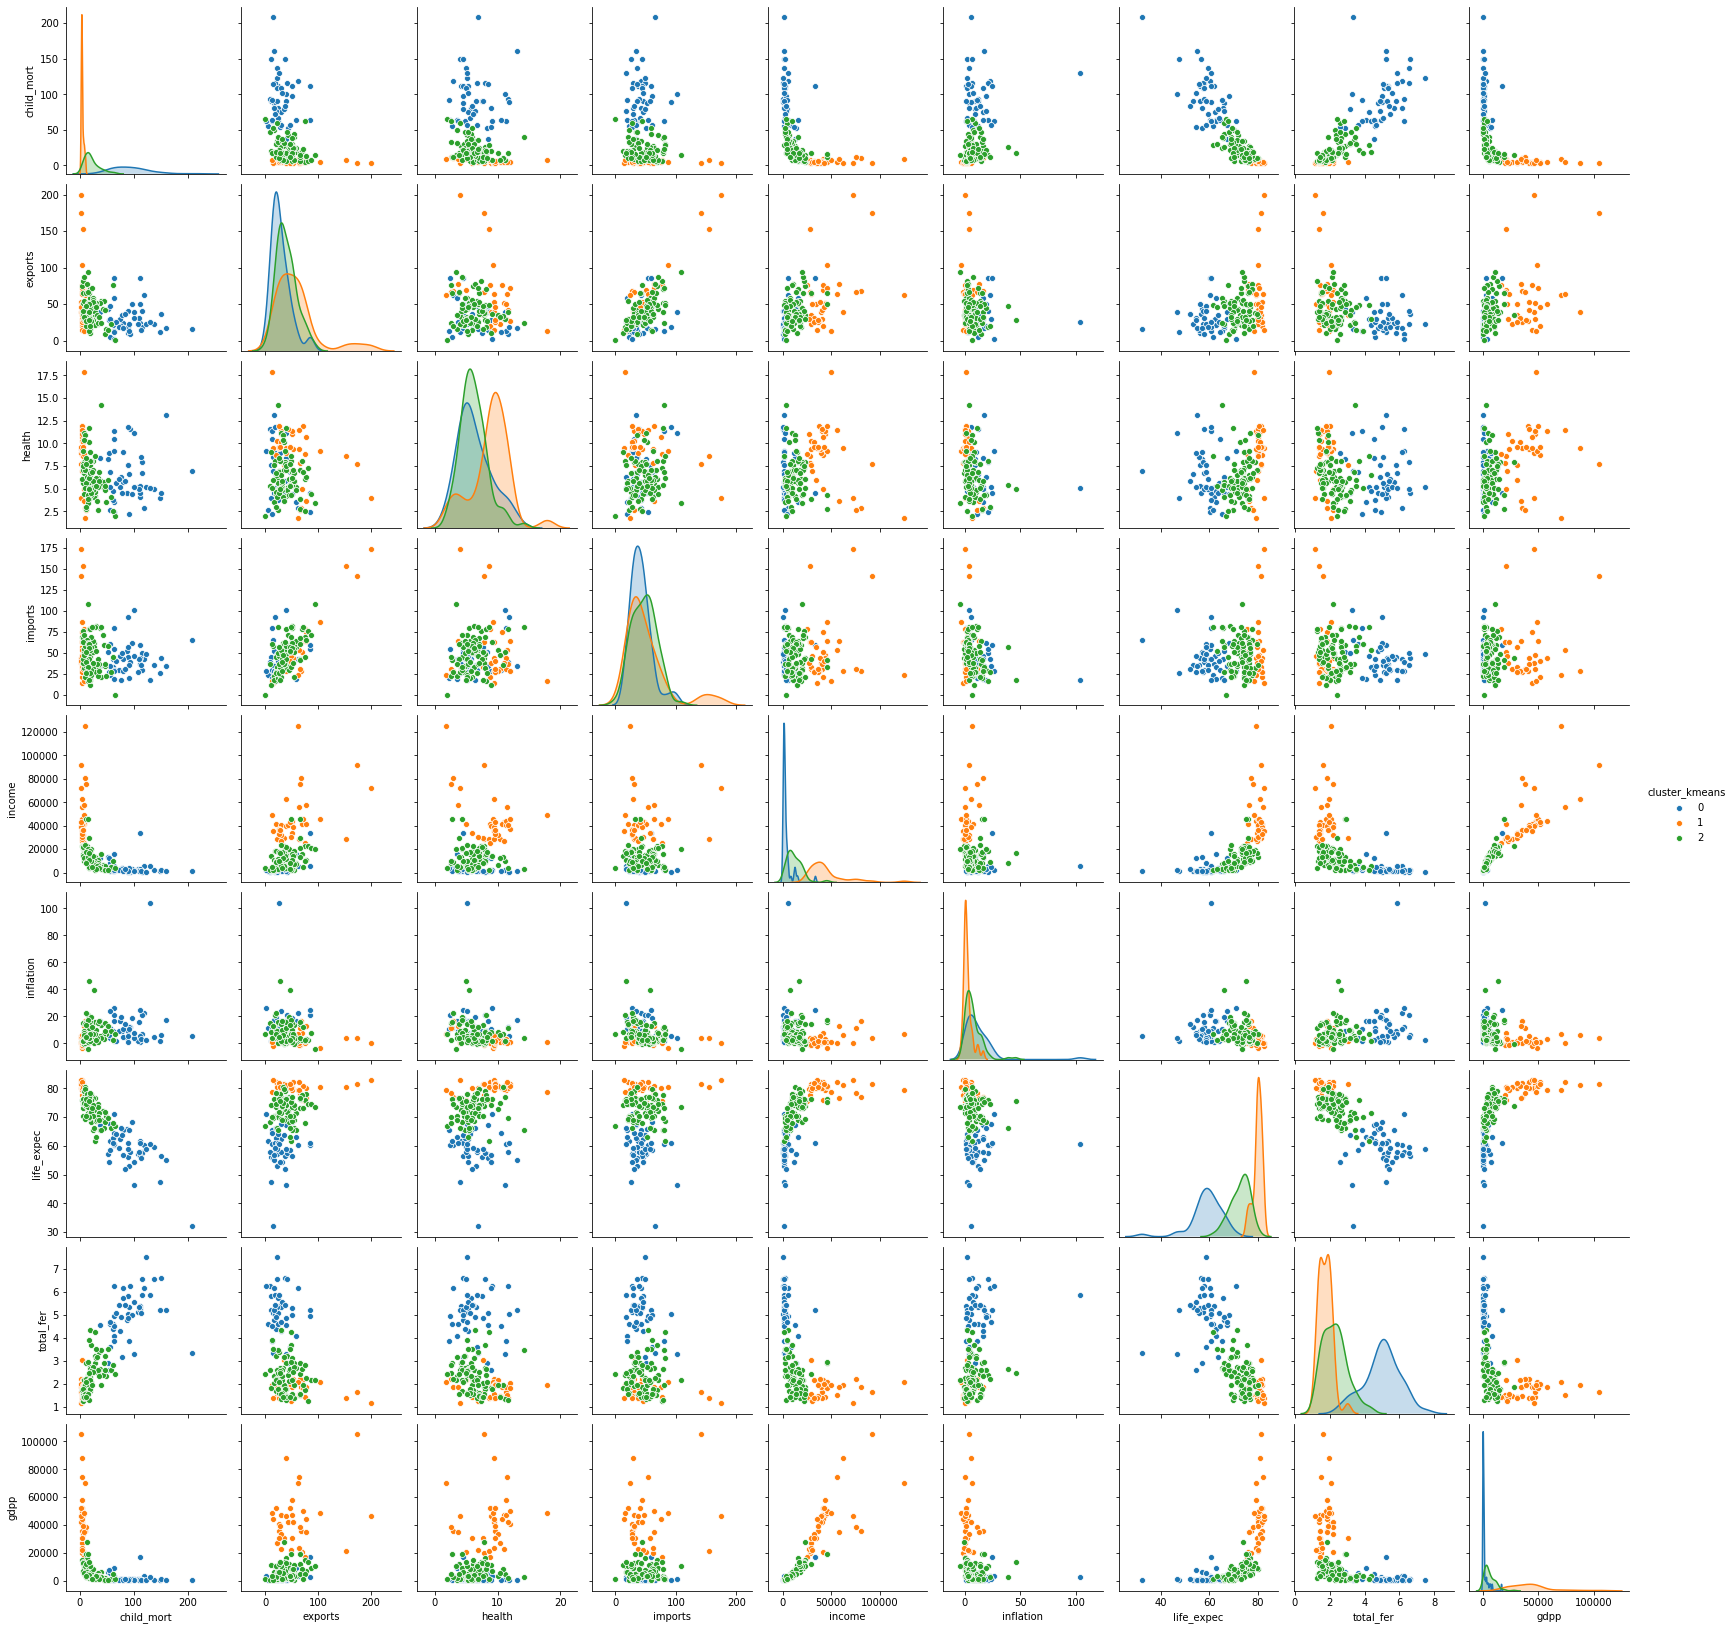

In [98]:
sns.pairplot(df.drop('kmeans_centrdist',axis=1),hue='cluster_kmeans')

Some notable distinctions between the clusters can be observed when plotting the relationship between features. 

For instance when looking at fertility rate vs GDP -  cluster 0 has high fertility and low GDP, cluster 1 has low fertility and high GDP, and cluster 2 has lower fertility and lower GDP.

# Silhouette analysis

Silhouette analysis helps measure the quality of clusters created, in terms of how well samples are clustered into distinct groups of similar data points. A silhouette score is created for each data point by comparing the following:

- **Intra-cluster distance**: mean distance between the observation and all other data points in the same cluster (denote as A).
- **Nearest-cluster distance**: mean distance between the observation and all other data points of the next nearest cluster (denote as B). 

The score is calculated as (B - A)/max(A, B). Values range between 1 and -1. A score close to 1 means the point is much closer to all the other points in the cluster than it is to the points in the nearest cluster. Scores close to 0 mean that the point is as close to points in the same cluster as it is to points in the nearest cluster. 

If more points in the cluster have a higher score, this suggests the cluster is dense and well-separated from other clusters.
If more points in the cluster have a lower score, this suggests overlapping clusters.

Text(0.5, 1.0, 'Silhouette values for each cluster - average silhouette value 0.28')

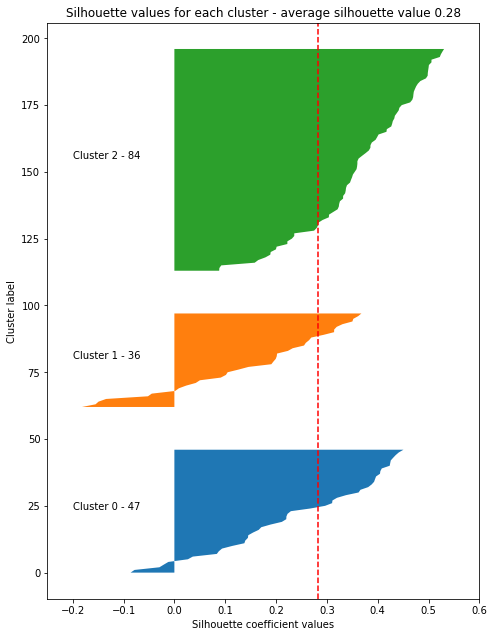

In [99]:
#Average silhouette value
silhouette_avg = silhouette_score(X_scaled, km.labels_)
sample_silhouette_values = silhouette_samples(X_scaled, km.labels_)

clusterstart = 0

fig=plt.figure(figsize=(6,8))
ax=fig.add_axes([0, 0, 1, 1])

for i in range(3):
    
    silhouette_cluster_i = sample_silhouette_values[km.labels_ == i]
    silhouette_cluster_i.sort()

    #Size of cluster
    size_cluster_i = silhouette_cluster_i.shape[0]
    clusterend = clusterstart + size_cluster_i

    ax.fill_betweenx(np.arange(clusterstart, clusterend),0, silhouette_cluster_i)

    # Label each cluster (with cluster size noted)
    ax.text(-0.2, clusterstart + 0.5 * size_cluster_i, "Cluster "+str(i)+" - "+str(size_cluster_i))

    # Start of next plot (add distance of 15 to separate clusters)
    clusterstart = clusterend + 15  

ax.set_xlim(-0.25,0.6)
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette values for each cluster - average silhouette value "+str(round(silhouette_avg,2)))

The average silhouette score (across all points in all clusters) is only 0.28, and even the highest scores in our clusters are only around 0.5. Although we have three segments which seem to have split countries into groups we can intuitively understand (i.e. highly developed, developing and very poor) these segments aren't particularly distinct from one another and there is a lot of overlap.

# Hierarchical Clustering

Hierarchical clustering is another clustering method that we can try. In this algorithm each observation starts in its own cluster, and clusters are progressively built by merging these together based on similarity.

A dendogram can help us find the optimum number of clusters to use.

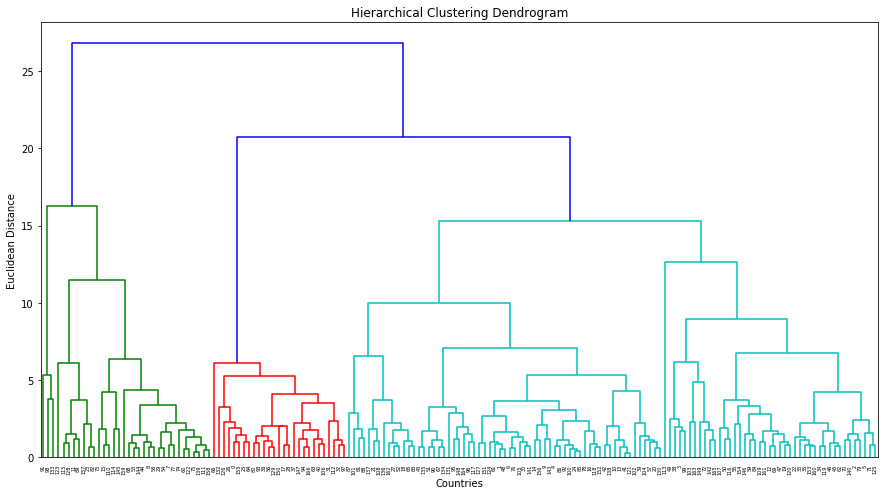

In [15]:
plt.figure(figsize=(15,8))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Euclidean Distance')
plt.show()

Similar to k-means, it seems 3 is the optimum number of clusters to use.

In [135]:

agglo = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
agglo.fit_predict(X_scaled)

df['cluster_hierarchical'] = agglo.labels_
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist,cluster_hierarchical
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,1.086090,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2,0.837031,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2,1.414632,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,2.267576,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,1.062536,1


In [136]:
for i in range(3):
    print('Countries in cluster ',i)
    display(df[df['cluster_hierarchical']==i].head(10))

Countries in cluster  0


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist,cluster_hierarchical
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1,2.007594,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,0.941836,0
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,1,2.025041,0
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,1,1.377696,0
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,1,3.341289,0
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,1,1.699617,0
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1,1.354821,0
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1,1.035765,0
54,France,4.2,26.8,11.90,28.1,36900,1.050,81.4,2.03,40600,1,1.969084,0
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,1,1.387329,0


Countries in cluster  1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist,cluster_hierarchical
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2,0.837031,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,2,1.414632,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,0,2.267576,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,2,1.062536,1
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,2,2.164925,1
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,2,1.115102,1
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,2,1.522748,1
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,2,1.687588,1
12,Bangladesh,49.4,16.0,3.52,21.8,2440,7.140,70.4,2.33,758,2,1.944605,1
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,2,1.242658,1


Countries in cluster  2


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist,cluster_hierarchical
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0,1.086090,2
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0,1.502218,2
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0,1.170171,2
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0,2.222401,2
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0,1.339560,2
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0,2.497591,2
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,0,2.010834,2
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,0,1.439264,2
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334,0,1.648369,2
40,Cote d'Ivoire,111.0,50.60,5.30,43.3,2690,5.390,56.3,5.27,1220,0,1.230611,2


In [102]:
df.groupby(['cluster_kmeans','cluster_hierarchical']).size()

cluster_kmeans  cluster_hierarchical
0               1                       20
                2                       27
1               0                       31
                1                        5
2               0                        3
                1                       81
dtype: int64

The segments for our hierarchical clustering and k-means clustering are fairly similar in the types of countries identified, except the hierarchical clustering has grouped a lot more of the poorest countries into the equivalent 'medium' group.

Looking at the group descriptions below, the countries that have swapped into the 'medium' segment appear to be significantly higher in measures like GDP per capita and income, but also have significantly higher inflation.

In [103]:
#Swapped population
display(df[(df['cluster_kmeans']==0) & (df['cluster_hierarchical'] ==1)].describe())

#Remained in poorest segment
display(df[(df['cluster_kmeans']==0) & (df['cluster_hierarchical'] ==2)].describe())

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist,cluster_hierarchical
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.0
mean,76.615000,36.659500,6.228500,45.915000,7118.500000,18.603500,61.805000,4.433500,3615.950000,0.0,2.590678,1.0
std,25.028411,23.416307,3.082271,24.752975,7615.661339,21.511003,5.425134,1.033249,3971.656588,0.0,1.600526,0.0
min,36.900000,2.200000,2.200000,17.200000,700.000000,1.520000,46.500000,2.590000,327.000000,0.0,0.978352,1.0
25%,56.225000,19.550000,4.182500,26.375000,2890.000000,8.277500,60.325000,3.780000,1192.500000,0.0,1.858839,1.0
50%,69.300000,32.700000,5.200000,44.400000,4380.000000,16.600000,61.300000,4.585000,1910.000000,0.0,2.186097,1.0
75%,93.425000,48.525000,8.542500,59.350000,9345.000000,21.125000,65.550000,4.990000,4672.500000,0.0,2.801302,1.0
max,130.000000,85.800000,11.800000,101.000000,33700.000000,104.000000,71.100000,6.230000,17100.000000,0.0,8.869483,1.0


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_kmeans,kmeans_centrdist,cluster_hierarchical
count,27.000000,27.00000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.0
mean,105.070370,23.58963,6.507037,39.662963,1589.740741,7.142778,57.248148,5.433704,667.888889,0.0,1.636770,2.0
std,33.987914,10.35961,2.358064,9.555753,650.612114,5.423793,6.540076,0.834530,304.547121,0.0,0.785621,0.0
min,62.200000,8.92000,3.770000,26.500000,609.000000,0.885000,32.100000,3.330000,231.000000,0.0,0.829088,2.0
25%,82.050000,16.65000,4.955000,32.250000,1200.000000,2.580000,55.900000,5.055000,452.500000,0.0,1.193809,2.0
50%,101.000000,22.20000,5.690000,39.200000,1430.000000,5.450000,57.700000,5.340000,575.000000,0.0,1.439264,2.0
75%,116.000000,27.65000,7.615000,44.200000,1900.000000,10.020000,60.150000,5.845000,763.500000,0.0,1.899215,2.0
max,208.000000,50.60000,13.100000,64.700000,3280.000000,20.800000,65.900000,7.490000,1460.000000,0.0,4.507446,2.0


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\patri\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


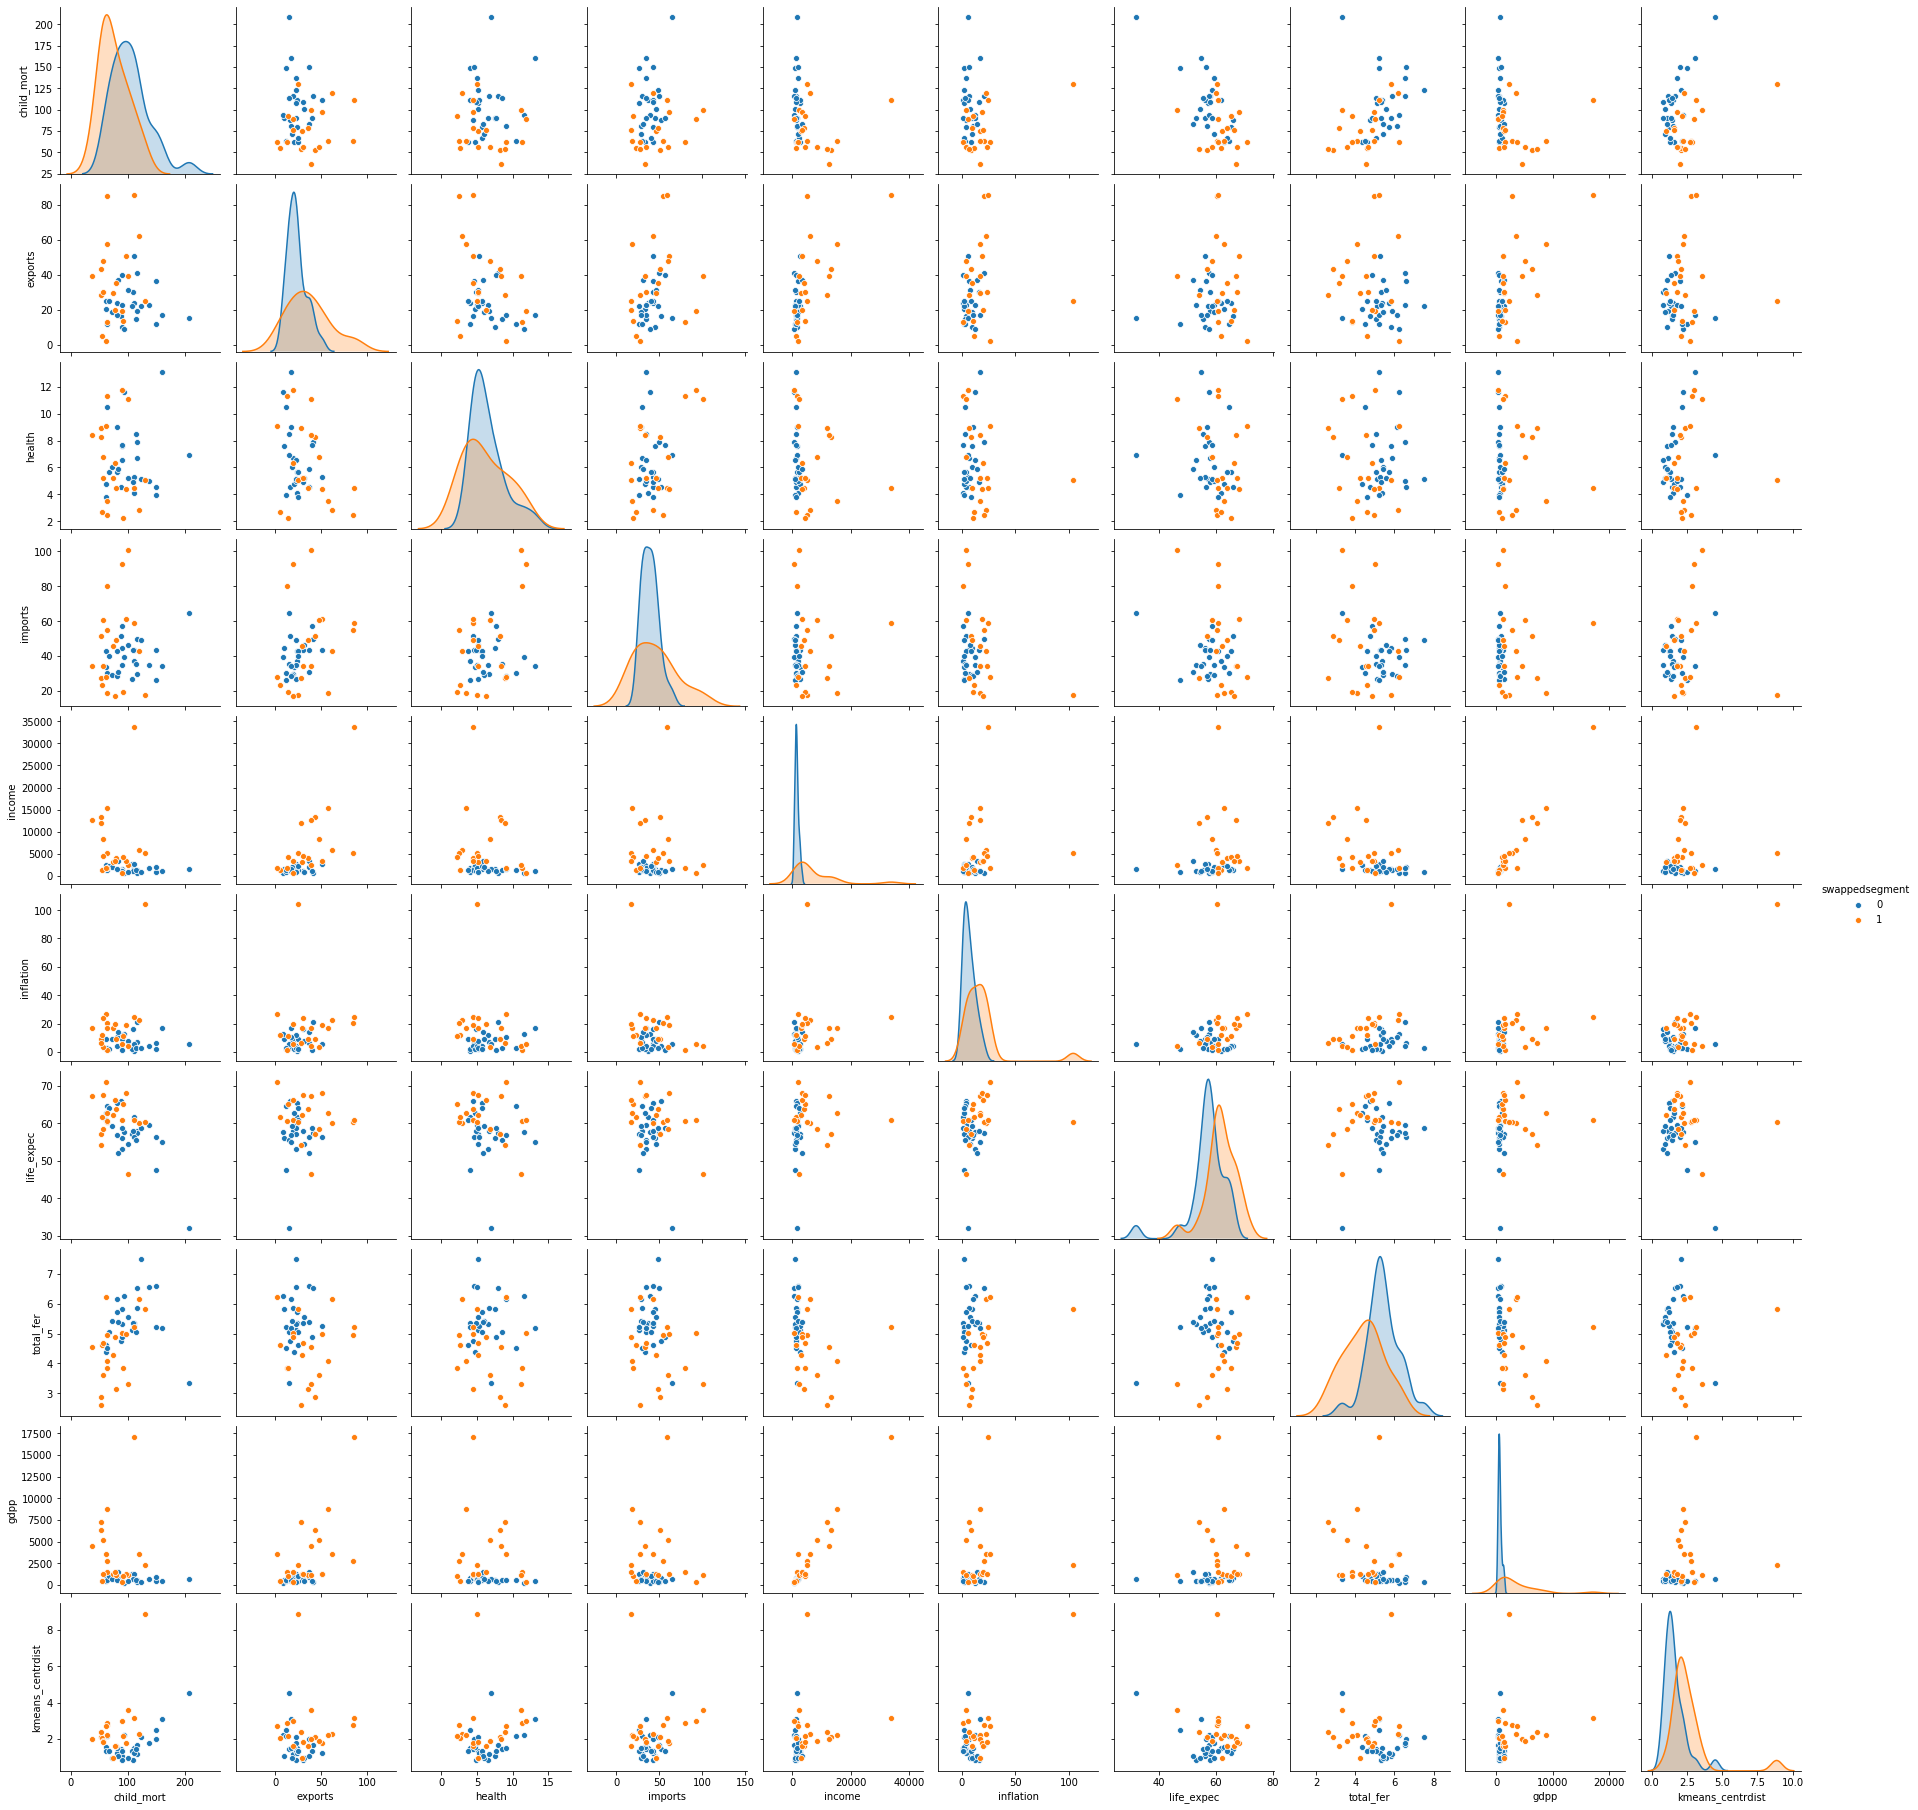

In [104]:
def flagswap(agglo):
    if agglo==1:
        return 1
    else:
        return 0

explore_swap=df[df['cluster_kmeans']==0]
explore_swap['swappedsegment']=explore_swap['cluster_hierarchical'].apply(lambda x: flagswap(x))
explore_swap.drop(['cluster_kmeans','cluster_hierarchical'],axis=1,inplace=True)

sns.pairplot(explore_swap,hue='swappedsegment')

# Silhouette analysis for hierarchical clusters

Text(0.5, 1.0, 'Silhouette values for each cluster - average silhouette value 0.25')

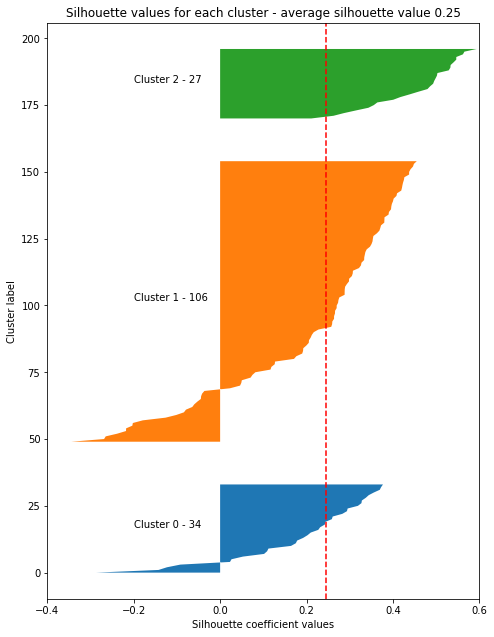

In [105]:
#Average silhouette value
silhouette_avg = silhouette_score(X_scaled, agglo.labels_)

sample_silhouette_values = silhouette_samples(X_scaled, agglo.labels_)
  
clusterstart = 0

fig=plt.figure(figsize=(6,8))
ax=fig.add_axes([0, 0, 1, 1])

for i in range(3):
    
    silhouette_cluster_i = sample_silhouette_values[agglo.labels_ == i]
    silhouette_cluster_i.sort()

    #Size of cluster
    size_cluster_i = silhouette_cluster_i.shape[0]
    clusterend = clusterstart + size_cluster_i

    ax.fill_betweenx(np.arange(clusterstart, clusterend),0, silhouette_cluster_i)

    # Label each cluster (with cluster size noted)
    ax.text(-0.2, clusterstart + 0.5 * size_cluster_i, "Cluster "+str(i)+" - "+str(size_cluster_i))

    # Start of next plot (add distance of 15 to separate clusters)
    clusterstart = clusterend + 15  

ax.set_xlim(-0.4,0.6)
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette values for each cluster - average silhouette value "+str(round(silhouette_avg,2)))

The average silhouette score using hierarchical clustering is 0.25, so slightly worse than k-means. There is also a significantly bigger proportion of the medium group that has negative scores, suggesting this segment now has a lot of overlap. 

# Clustering with PCA

Clustering in a reduced dimensional space with the use of PCA may allow us to visualise the clustering better.

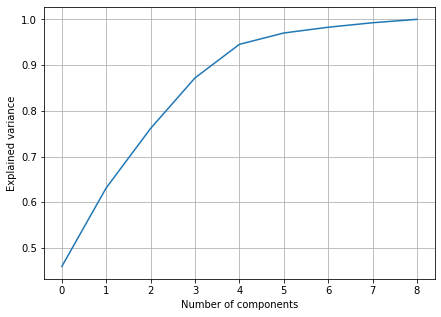

In [106]:
pca = PCA().fit(X_scaled)

plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid(True)

**65%** of the variance in the data is captured in the first principal component alone. **77%** is captured using the first two components and **88%** is captured using the first three.

Interestingly this suggests that most of the variance in the data can be explained by a single dimension, meaning that the features explain mostly the same information about the country's socio-economic status. This makes sense as generally we see the measures of wealth & poverty correlate strongly with each other. For instance we generally expect countries with higher GDP and income to have better access to healthcare, reducing mortality rate and increasing life expectancy. 

In [137]:
X_reduced_pca = PCA().fit_transform(X_scaled)
X_reduced_pca.shape

(167, 9)

In [138]:
df_pca=pd.DataFrame(X_reduced_pca,columns=['pca'+str(i) for i in range(1,10,1)])
df_join_pca=pd.concat([df,df_pca],axis=1)
df_join_pca.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,cluster_hierarchical,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,...,2,-2.913025,0.095621,-0.718118,1.005255,-0.158310,-0.254597,0.383000,0.415076,-0.014148
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,...,1,0.429911,-0.588156,-0.333486,-1.161059,0.174677,0.084579,0.248919,-0.221042,0.173316
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,...,1,-0.285225,-0.455174,1.221505,-0.868115,0.156475,-0.401696,-0.087214,-0.184162,0.084037
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,...,1,-2.932423,1.695555,1.525044,0.839625,-0.273209,-0.547996,-0.440835,-0.355998,-0.091339
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,...,1,1.033576,0.136659,-0.225721,-0.847063,-0.193007,-0.206919,0.241978,-0.023681,0.094270


#### Repeat inertia analysis

C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


Text(0.5, 1.0, 'Number of clusters - inertia')

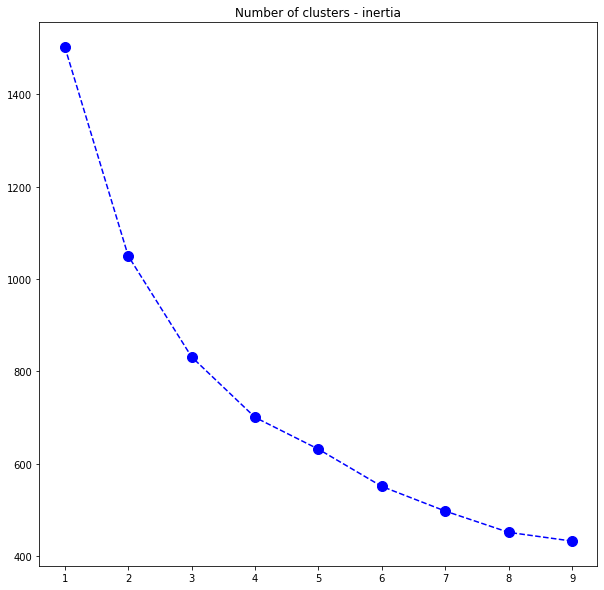

In [39]:
inertia = []

for i in range(1, 10):
    km = KMeans(n_clusters = i , init = 'k-means++')
    km.fit(X_reduced_pca)
    inertia.append(km.inertia_)

fig=plt.figure(figsize=(10,10))
plt.plot(range(1,10),inertia,color='blue', linestyle='dashed', marker='o',markerfacecolor='Blue', markersize=10,label='Inertia')
plt.title('Number of clusters - inertia')

We'll use K=3 again.

In [139]:
#--------Run k-means ------------
km = KMeans(n_clusters = 3 , init = 'k-means++')
km.fit(X_reduced_pca)
df_join_pca['pca_cluster_kmeans'] = km.labels_

#--------Cluster volumes and centre points------------

print('Number of countries in each cluster')
display(df_join_pca['pca_cluster_kmeans'].value_counts().sort_index())

clusters = pd.DataFrame(km.cluster_centers_,index=[0,1,2],columns=['pca'+str(i) for i in range(1,10,1)])
print('Cluster centres')
display(clusters)


#--------Calculate distances between each point and the centre of its cluster------------

distances=[]

for i in range(len(km.labels_)):
    cluster=km.labels_[i]
    distances.append(np.linalg.norm(X_reduced_pca[i]-km.cluster_centers_[cluster]))
    
df_join_pca['pca_kmeans_centrdist'] = distances


#--------Show countries in each cluster that are most representative (closest to clustre centre)------------
for i in range(3):
    print('Countries in cluster ',i)
    display(df_join_pca[df_join_pca['pca_cluster_kmeans']==i].sort_values('pca_kmeans_centrdist').head(10))

Number of countries in each cluster


0    36
1    84
2    47
Name: pca_cluster_kmeans, dtype: int64

Cluster centres


,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,2.769773,-0.213014,0.068886,0.866801,-0.178226,-0.026261,0.021584,-0.048665,0.000026
1,0.175182,-0.138827,0.024285,-0.758514,0.155532,0.035939,0.005567,0.007873,0.001733
2,-2.434620,0.411276,-0.096167,0.691710,-0.141458,-0.044116,-0.026482,0.023204,-0.003116


Countries in cluster  0


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca_cluster_kmeans,pca_kmeans_centrdist
68,Iceland,2.6,53.4,9.40,43.3,38800,5.470,82.0,2.20,41900,...,-0.634702,0.103795,0.919853,0.112795,-0.404524,-0.092346,-0.120300,-0.155874,0,0.731764
144,Sweden,3.0,46.2,9.63,40.7,42900,0.991,81.5,1.98,52100,...,-0.914481,-0.101807,1.242279,-0.331557,-0.224330,0.114738,-0.187697,-0.341840,0,0.933892
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,...,-0.734689,-0.519766,1.205442,0.083580,0.099255,-0.051831,-0.156019,-0.104369,0,0.941836
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,...,-1.076143,-0.100439,0.899328,-0.464733,-0.084646,0.184458,-0.109401,-0.292843,0,1.035765
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,...,-0.865549,-0.335752,1.787223,0.102687,-0.008163,0.010744,-0.135653,-0.503918,0,1.354821
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,...,0.663548,-0.645228,1.094898,0.439734,-0.176984,-0.041183,-0.108034,-0.125496,0,1.377696
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,...,-1.273610,-0.656171,1.125993,0.143391,0.156425,-0.220636,-0.089438,-0.010584,0,1.387329
110,Netherlands,4.5,72.0,11.90,63.6,45500,0.848,80.7,1.79,50300,...,0.115702,-0.738130,1.543035,0.370062,-0.127441,-0.218905,-0.112882,-0.136439,0,1.406915
42,Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,...,-0.004510,0.257320,-0.311857,-0.414668,0.038125,0.424195,-0.209959,-0.040676,0,1.439596
135,Slovenia,3.2,64.3,9.41,62.9,28700,-0.987,79.5,1.57,23400,...,0.195275,-0.801535,-0.067360,0.242751,-0.108573,-0.273236,-0.064987,0.135583,0,1.525426


Countries in cluster  1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca_cluster_kmeans,pca_kmeans_centrdist
76,Jamaica,18.1,31.3,4.81,49.6,8000,9.810,74.7,2.17,4680,...,-0.238961,0.333750,-1.222456,0.170524,-0.053225,0.401479,-0.152645,-0.053701,1,0.734379
143,Suriname,24.1,52.5,7.01,38.4,14200,7.200,70.3,2.52,8300,...,-0.094808,0.012026,-0.376834,0.110104,0.113329,-0.583965,0.191737,-0.127388,1,0.744218
118,Paraguay,24.1,55.1,5.87,51.5,7290,6.100,74.1,2.73,3230,...,0.361031,-0.046672,-0.946839,0.130347,-0.342943,-0.326617,-0.087266,-0.054227,1,0.748573
152,Tunisia,17.4,50.5,6.21,55.3,10400,3.820,76.9,2.14,4140,...,0.173436,-0.243158,-1.117937,0.136754,-0.254155,-0.132611,-0.193591,0.118183,1,0.798961
48,El Salvador,19.2,26.9,6.91,46.6,7300,2.650,74.1,2.27,2990,...,-0.567804,-0.575878,-0.976521,0.045804,-0.090355,0.151620,-0.038173,0.080522,1,0.811234
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,...,-0.588156,-0.333486,-1.161059,0.174677,0.084579,0.248919,-0.221042,0.173316,1,0.837031
124,Romania,11.5,32.6,5.58,38.8,17800,3.530,73.7,1.59,8230,...,-0.637385,0.086351,-1.029839,-0.314844,0.328296,0.066086,0.074435,0.057161,1,0.895553
105,Morocco,33.5,32.2,5.20,43.0,6440,0.976,73.5,2.58,2830,...,-0.281028,-0.261357,-1.076394,-0.500666,-0.161930,0.035503,-0.242050,0.044512,1,0.950948
61,Grenada,14.6,23.8,5.86,49.2,11200,0.480,71.3,2.24,7370,...,-0.431336,-0.470468,-0.971168,-0.384509,0.115061,0.450199,0.178250,-0.088395,1,0.953519
141,St. Vincent and the Grenadines,20.7,26.9,4.47,57.1,9920,4.440,71.6,2.07,6230,...,-0.016064,-0.038546,-1.224842,-0.267734,0.202641,0.693707,-0.035569,-0.076008,1,0.973120


Countries in cluster  2


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca_cluster_kmeans,pca_kmeans_centrdist
63,Guinea,109.0,30.3,4.93,43.2,1190,16.10,58.0,5.34,648,...,0.728534,0.391039,0.666549,-0.192543,-0.054612,0.080386,-0.194853,-0.033354,2,0.829088
94,Malawi,90.5,22.8,6.59,34.9,1030,12.10,53.1,5.31,459,...,0.216622,-0.204596,0.839108,-0.228962,0.204560,-0.097821,0.454170,-0.266818,2,0.835789
106,Mozambique,101.0,31.5,5.21,46.2,918,7.64,54.5,5.56,419,...,0.893270,-0.258704,0.633835,-0.702221,-0.027944,0.021720,0.193554,-0.180542,2,0.935812
147,Tanzania,71.9,18.7,6.01,29.1,2090,9.25,59.3,5.43,702,...,-0.215028,-0.088490,0.462226,-0.474937,-0.362561,-0.048905,0.453413,-0.211794,2,0.949202
59,Ghana,74.7,29.5,5.22,45.9,3060,16.60,62.2,4.27,1310,...,0.380034,0.419654,0.090971,0.183829,0.040180,0.220072,-0.029883,-0.092380,2,0.978352
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,...,0.485998,0.223167,0.816364,-0.274068,0.201378,-0.442185,0.664338,-0.441482,2,1.077681
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,...,0.095621,-0.718118,1.005255,-0.158310,-0.254597,0.383000,0.415076,-0.014148,2,1.086090
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.81,57.9,5.87,575,...,0.038775,-0.455751,1.080918,-0.728128,-0.287178,-0.227066,-0.119449,0.112434,2,1.170171
56,Gambia,80.3,23.8,5.69,42.7,1660,4.30,65.5,5.71,562,...,0.223496,-0.393111,0.289914,-0.694393,-0.943948,0.130492,-0.015679,0.079912,2,1.217447
40,Cote d'Ivoire,111.0,50.6,5.30,43.3,2690,5.39,56.3,5.27,1220,...,1.207873,-0.233066,0.665293,-0.852981,0.007905,-0.576385,-0.115100,-0.094050,2,1.230611


In [140]:
agglo = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
agglo.fit_predict(X_reduced_pca)

df_join_pca['pca_cluster_hierarchical'] = agglo.labels_
df_join_pca.head()

for i in range(3):
    print('Countries in cluster ',i)
    display(df_join_pca[df_join_pca['pca_cluster_hierarchical']==i].head(10))

Countries in cluster  0


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca_cluster_kmeans,pca_kmeans_centrdist,pca_cluster_hierarchical
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,...,0.190344,1.105038,-0.731192,-0.156455,0.382386,-0.267776,-0.350631,0,2.007594,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,...,-0.519766,1.205442,0.083580,0.099255,-0.051831,-0.156019,-0.104369,0,0.941836,0
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,...,0.991258,-0.207080,-0.392572,0.008028,-0.194478,0.306524,0.264935,0,2.025041,0
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,...,-0.645228,1.094898,0.439734,-0.176984,-0.041183,-0.108034,-0.125496,0,1.377696,0
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,...,3.019840,0.776841,-1.031809,0.530662,-0.032761,0.636673,0.887730,0,3.341289,0
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,...,-0.396281,1.336853,0.065723,0.019062,0.099935,-0.201962,-0.128761,0,1.699617,0
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,...,-0.335752,1.787223,0.102687,-0.008163,0.010744,-0.135653,-0.503918,0,1.354821,0
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,...,-0.100439,0.899328,-0.464733,-0.084646,0.184458,-0.109401,-0.292843,0,1.035765,0
54,France,4.2,26.8,11.90,28.1,36900,1.050,81.4,2.03,40600,...,-0.711988,1.230005,0.107391,-0.232849,-0.083196,-0.060388,-0.004612,0,1.969084,0
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,...,-0.656171,1.125993,0.143391,0.156425,-0.220636,-0.089438,-0.010584,0,1.387329,0


Countries in cluster  1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca_cluster_kmeans,pca_kmeans_centrdist,pca_cluster_hierarchical
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,...,-0.333486,-1.161059,0.174677,0.084579,0.248919,-0.221042,0.173316,1,0.837031,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,...,1.221505,-0.868115,0.156475,-0.401696,-0.087214,-0.184162,0.084037,1,1.414632,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,...,1.525044,0.839625,-0.273209,-0.547996,-0.440835,-0.355998,-0.091339,2,2.267576,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,...,-0.225721,-0.847063,-0.193007,-0.206919,0.241978,-0.023681,0.094270,1,1.062536,1
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,...,0.869997,-0.036967,0.981057,-0.003596,-0.150832,0.125950,0.126079,1,2.164925,1
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,...,0.242092,-1.466266,-0.055992,0.282469,0.546907,-0.168164,-0.065629,1,1.115102,1
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,...,0.867459,-0.438773,0.137350,0.637836,-0.963776,-0.063190,-0.035275,1,1.522748,1
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,...,-0.488098,0.055634,-0.380250,0.229558,0.163583,-0.036086,-0.325640,1,1.687588,1
12,Bangladesh,49.4,16.0,3.52,21.8,2440,7.140,70.4,2.33,758,...,0.526615,-1.197201,-0.669166,0.312502,0.058975,-0.446637,-0.079200,1,1.944605,1
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,...,-0.664355,-0.522505,0.002624,-0.010978,-0.024045,-0.205950,-0.054503,1,1.242658,1


Countries in cluster  2


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca_cluster_kmeans,pca_kmeans_centrdist,pca_cluster_hierarchical
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,...,-0.718118,1.005255,-0.158310,-0.254597,0.383000,0.415076,-0.014148,2,1.086090,2
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,...,-0.257368,0.278672,-1.431768,-0.383177,0.035007,-0.425902,0.131749,2,1.502218,2
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,...,-0.455751,1.080918,-0.728128,-0.287178,-0.227066,-0.119449,0.112434,2,1.170171,2
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,...,-1.347413,1.821474,0.712117,-0.527420,-0.070907,0.457048,0.180289,2,2.222401,2
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,...,-0.342961,0.543557,-1.314868,0.064148,-0.254332,-0.120344,-0.024238,2,1.339560,2
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,...,-0.323557,0.918301,-1.822389,0.888603,-0.011419,-0.284557,-0.046861,2,2.497591,2
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,...,-0.103015,1.208406,-1.224562,-0.440268,-0.193705,-0.556235,0.222851,2,2.010834,2
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,...,-0.328381,-0.118947,-0.808030,-0.457255,0.611996,-0.404360,0.181330,2,1.439264,2
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334,...,-0.001219,1.574210,0.647909,-0.581699,-0.266317,0.002067,0.067794,2,1.648369,2
40,Cote d'Ivoire,111.0,50.60,5.30,43.3,2690,5.390,56.3,5.27,1220,...,-0.233066,0.665293,-0.852981,0.007905,-0.576385,-0.115100,-0.094050,2,1.230611,2


#### Plot clusters using first 2 PCA components

Text(0.5, 1.0, 'Hierarchical clusters using features')

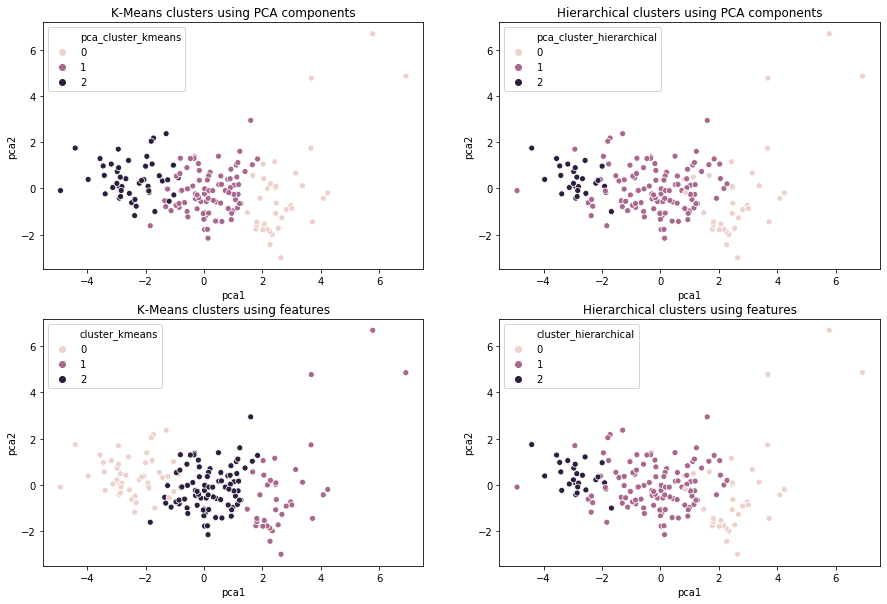

In [141]:

plt.figure(figsize=(15, 10))

plt.subplot(221)
sns.scatterplot(data=df_join_pca, x="pca1", y="pca2",hue="pca_cluster_kmeans")
plt.title('K-Means clusters using PCA components')

plt.subplot(222)
sns.scatterplot(data=df_join_pca, x="pca1", y="pca2",hue="pca_cluster_hierarchical")
plt.title('Hierarchical clusters using PCA components')

plt.subplot(223)
sns.scatterplot(data=df_join_pca, x="pca1", y="pca2",hue="cluster_kmeans")
plt.title('K-Means clusters using features')

plt.subplot(224)
sns.scatterplot(data=df_join_pca, x="pca1", y="pca2",hue="cluster_hierarchical")
plt.title('Hierarchical clusters using features')

We can see from the diagrams above that the clustering algorithms are essentially splitting the data into 3 along the first component, which we already know accounts for the majority of the variance.

It can also be seen how the hierarchical algorithm is assigning a larger chunk of the poorest countries into the medium segment. As a result this segment has expanded in range, which would increase the average intra-cluster distance and likely explains the increase in negative silhouette scores. 

#### Plot clusters using first 3 PCA components

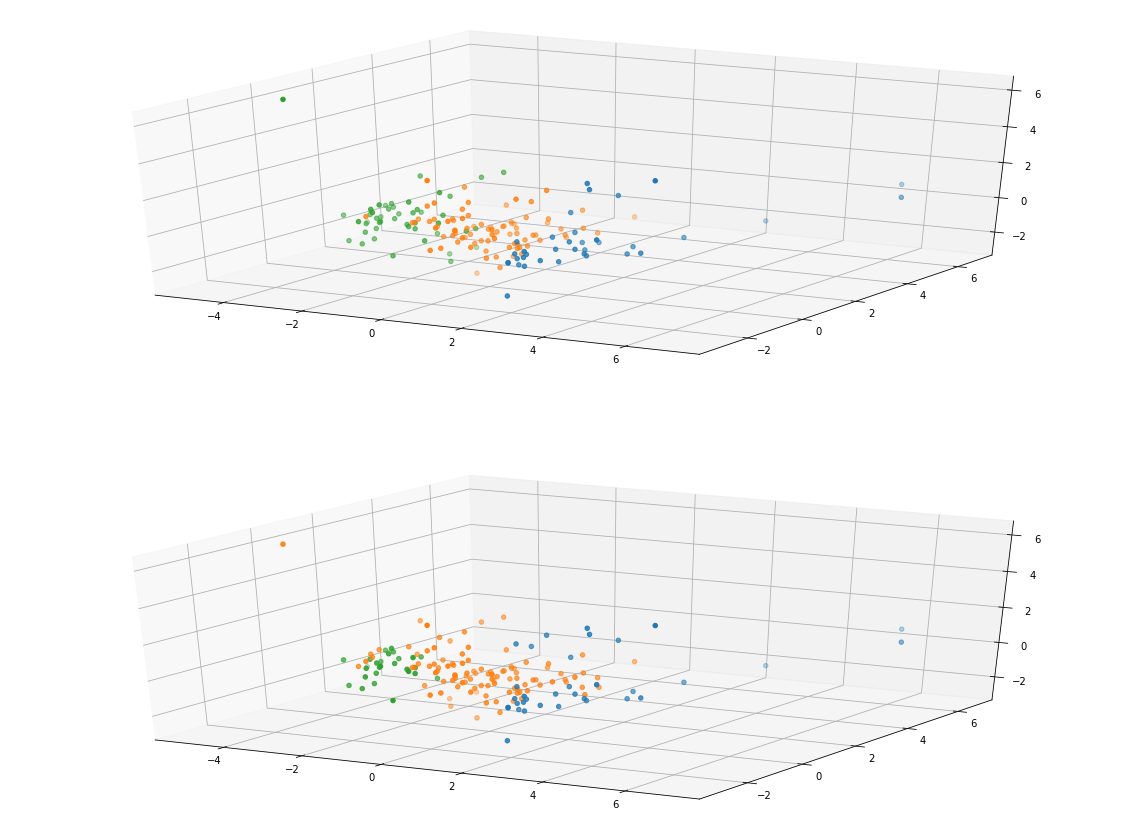

In [142]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(211, projection='3d')

ax.set_title('K-Means clusters using PCA components')
cluster_0=df_join_pca[df_join_pca["pca_cluster_kmeans"]==0]
cluster_1=df_join_pca[df_join_pca["pca_cluster_kmeans"]==1]
cluster_2=df_join_pca[df_join_pca["pca_cluster_kmeans"]==2]

ax1.scatter(cluster_0["pca1"], cluster_0["pca2"], cluster_0["pca3"])
ax1.scatter(cluster_1["pca1"], cluster_1["pca2"], cluster_1["pca3"])
ax1.scatter(cluster_2["pca1"], cluster_2["pca2"], cluster_2["pca3"])


ax2 = fig.add_subplot(212, projection='3d')

ax.set_title('Hierarchical clusters using PCA components')
cluster_0=df_join_pca[df_join_pca["pca_cluster_hierarchical"]==0]
cluster_1=df_join_pca[df_join_pca["pca_cluster_hierarchical"]==1]
cluster_2=df_join_pca[df_join_pca["pca_cluster_hierarchical"]==2]

ax2.scatter(cluster_0["pca1"], cluster_0["pca2"], cluster_0["pca3"])
ax2.scatter(cluster_1["pca1"], cluster_1["pca2"], cluster_1["pca3"])
ax2.scatter(cluster_2["pca1"], cluster_2["pca2"], cluster_2["pca3"])



In conclusion, both clustering methods segmented countries fairly similarly into three groups - identifying wealthy, developed nations as one cluster, severely underdeveloped countries into another cluster, and the bulk of countries into a 'medium' segment.

When reducing dimensionality by using PCA, we saw most of the variance between countries could be explained by the first component, suggesting a lot of correlation between variables in the dataset. We saw that both clustering methods were essentially splitting into groups along the axis of this first component. 